Néophyte dans le commerce d'automobiles d'occasion, je me suis lancé à la recherche d'une C3 picasso , c'est un bon compromis pour vivre à la campagne. Mais il ne suffit pas de savoir quelle voiture on veut acheter, il faut la trouver au juste prix.

Le prix dépend de la côte argus, référence depuis un siècle pour prendre en compte l'usure d'une voiture. Mais aujourd’hui d'autres sites proposent eux aussi leur propre mode de calcul. En revanche aucun d'entre eux ne proposent de graphique pour montrer la répartition du marché d'occasion. Ils nous obligent à cliquer et à faire défiler les pages en espérant que le futur acheteur y comprenne quelque chose dans cette marée de paramètres.

Je me suis donc fixé comme objectif de réaliser une analyse statistique des petites annonces pour m'aider à y voir plus clair.

In [1]:
import pandas as pd
import numpy as np
import time
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [2]:
# DFL1
xls = pd.ExcelFile('c3p total.xls')
dfl=pd.DataFrame()
#dfl=xls.parse(i0)
for i in xls.sheet_names[0:]:
    #n=i.split(' ')[0]
    dfi=xls.parse(i)
    dfl=pd.concat([dfl,dfi])
dfl=dfl.reset_index(drop=True)

In [3]:
dfl.head(2)

,page,page-href,prix,nkm,dpt,type,annee,vendeur
0,3,http://www.lacentrale.fr/listing_auto.php?tri=...,9 590 €,19 678 km,Dpt. 37,(2) 1.4 VTI 95 CONFORT,2011,Professionnel
1,3,http://www.lacentrale.fr/listing_auto.php?tri=...,8 490 €,50 449 km,Dpt. 38,(2) 1.4 VTI 95 CONFORT,2012,Professionnel


In [4]:
dfl=dfl.drop('page-href',1)
dfl=dfl.drop('page',1)
dfl=dfl.rename(columns = {'type':'version'})

In [5]:
(dfl.index.duplicated()).sum()

0

# TRI
passer les données textes en valeurs numeriques

In [11]:
df=dfl.copy()

In [12]:
df.sample()

,prix,nkm,dpt,version,annee,vendeur
1064,12 990 €,58 567 km,Dpt. 56,(2) 1.6 HDI 90 FAP CONFORT,2015,Professionnel


### prix

In [13]:
df['prix']=df.prix.str.split().apply(lambda x : int(x[0]+x[1]))

In [14]:
df['prix']=pd.to_numeric(df.prix, errors='coerce').fillna(0).astype(np.int64)

### km

In [15]:
df['nkm']=df.nkm.str.replace('km', '')
df['nkm']=df.nkm.str.replace(u'\xa0', u'')
df['nkm']=pd.to_numeric(df.nkm, errors='coerce').fillna(0).astype(np.int64)

In [44]:
# noveau parametre petit moyen et grand kilometrage 
df['nkm2']=df.nkm.apply(lambda x: '<40k' if x <=40000 else '<90k' if x<=90000 else '>90k')

### Version/modele
Recuperer les information carburant / cylindré / finition / puissance de la colonne version

In [16]:
df.version=df.version.str.replace(r"\(.*\)","")

df.version.value_counts().head(10)

In [23]:
dfv=df.version.str.split(expand=True)
dfv.sample(5)

,0,1,2,3,4,5,6,7
341,1.6,HDI,90,EXCLUSIVE,None,None,None,None
1776,1.6,BLUEHDI,100,CONFORT,None,None,None,None
700,1.6,HDI,90,FAP,CONFORT,None,None,None
1393,BLUEHDI,100,CONFORT,None,None,None,None,None
1187,1.6,HDI,90,FAP,CONFORT,None,None,None


#### carburant

In [24]:
df['carburant']=np.nan
df['carburant']=df.version.apply(lambda x: 'diesel' if 'HDI' in x else 'essence')
df.carburant.isnull().sum()

0

In [25]:
df.carburant.value_counts()

diesel     1733
essence     307
Name: carburant, dtype: int64

#### puissance

In [27]:
#liste des valeurs
dfv.iloc[:,2].value_counts().head(10)

90         873
100        521
110        296
CONFORT     85
115         75
95          64
92          36
120         22
100CH       21
FAP         14
Name: 2, dtype: int64

In [29]:
f_list=['90','92','95','100','110','115','120']
df['puissance']=np.nan
for i in f_list:
    mask = df.version.str.contains(i)
    df.loc[mask,'puissance']=i
print df.puissance.isnull().sum()

7


In [30]:
df.puissance=pd.to_numeric(df.puissance, errors='coerce').fillna(0).astype(np.int64)

In [31]:
df.puissance.value_counts()

90     882
100    647
110    297
115     78
95      65
92      40
120     24
0        7
Name: puissance, dtype: int64

Nouveau parametre si puissance > ou < 100 ch

In [80]:
# nouveau paramettre 
df['puissance2']=df.puissance.map(lambda x : '>100' if x>=100 else '<100')

In [34]:
df.puissance2.value_counts()

1    1046
0     994
Name: puissance2, dtype: int64

#### cylindre

In [35]:
f_list=['1.6','1.4','1.2']
df['cylindre']=np.nan
for i in f_list:
    mask = df.version.str.contains(i)
    df.loc[mask,'cylindre']=i
print df.cylindre.isnull().sum()

126


126 resultat sans valeur de cylindré 

In [36]:
df.version[df.cylindre.isnull()].value_counts().head()

BLUEHDI 100 CONFORT         80
BLUEHDI 100 EXCLUSIVE       11
 HDI 90 FAP CONFORT          4
HDI 92 FAP BUSINESS          2
BLUE HDI 100 BVM CONFORT     2
Name: version, dtype: int64

qui correspondent principalement a des modele BLUEHDI donc a du  1.6L

In [37]:
mask = df.version.str.contains('BLUEHDI')
df.loc[mask,'cylindre']='1.6'

In [38]:
df.cylindre.value_counts()

1.6    1729
1.2     214
1.4      67
Name: cylindre, dtype: int64

#### finition

In [39]:
df.version.str.split().str[-1].value_counts().head(10)

CONFORT       818
EXCLUSIVE     361
EDITION       280
MILLENIUM     143
BUSINESS      110
COLLECTION     98
BMP6           52
ATTRACTION     42
PACK           27
BV6            25
Name: version, dtype: int64

In [54]:
f_list=['ATTRACTION','CONFORT','EXCLUSIVE','FEEL EDITION','MILLENIUM','BUSINESS','BUSINESS','COLLECTION','SELECTION','VITAMINE','ROSSIGNOL','MUSIC TOUCH']
df['finition']=np.nan
for i in f_list:
    mask = df.version.str.contains(i)
    df.loc[mask,'finition']=i
print df.finition.isnull().sum()

19


In [53]:
df.version[df.finition.isnull()].value_counts().head()

 1.6 HDI 90 MUSIC TOUCH      8
1.6 HDI 90 FAP ROSSIGNOL     6
 1.6 HDI 90 PASSION BLEUS    3
 1.6 HDI 90 ROSSIGNOL        2
1.6 HDI                      2
Name: version, dtype: int64

Calcul du nombre de cominaisons des parametres  'carburant', 'puissance',  'cylindre',  'finition' = 47 

In [58]:
col= ['carburant', 'puissance',  'cylindre',  'finition']
df2=df[col]
len(df2.groupby(col).finition.count())

51

# ANALYSE

In [51]:
df[['prix', 'nkm','carburant', 'puissance']].describe().round()

,prix,nkm,puissance
count,2040.0,2040.0,2040.0
mean,11784.0,50476.0,97.0
std,3033.0,41543.0,10.0
min,3499.0,1.0,0.0
25%,9494.0,17993.0,90.0
50%,11990.0,37898.0,100.0
75%,13990.0,77806.0,100.0
max,18990.0,306162.0,120.0


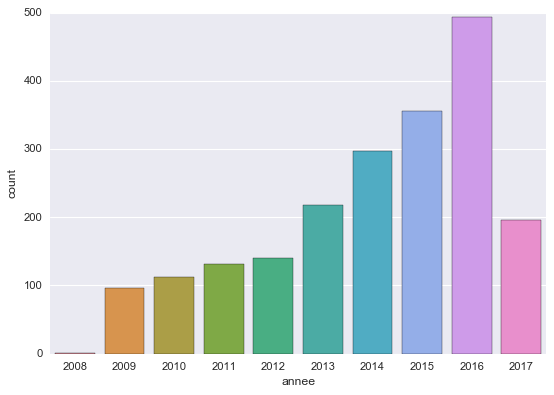

In [52]:
sns.set(style="darkgrid")
ax = sns.countplot(x="annee", data=df)

## ESSENCE / DIESEL

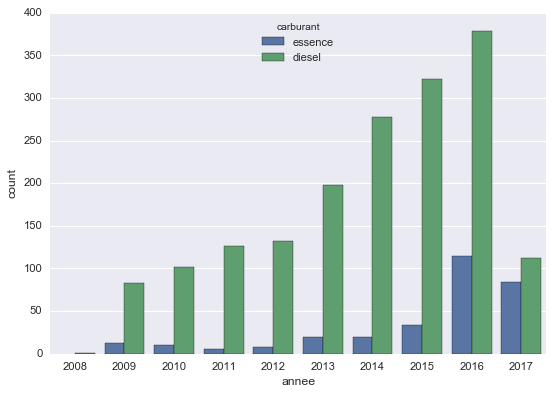

In [59]:
ax = sns.countplot(x="annee", hue="carburant", data=df)
#plt.savefig("annee-carburant.png")

[(6000, 20000)]

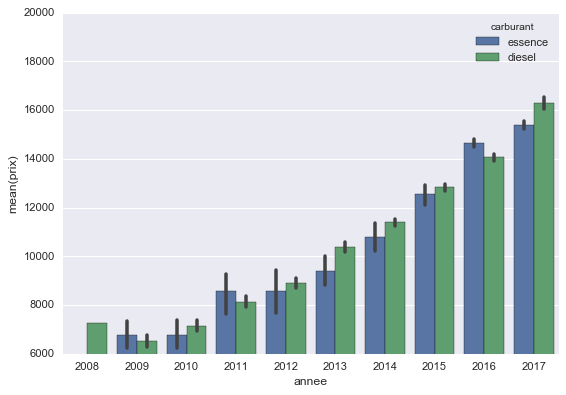

In [64]:
ax = sns.barplot(x="annee",y='prix', hue="carburant", data=df)
ax.set(ylim=(6000, 20000))

## Analyse des modeles diesel et focus sur les modeles < 2015 ce qui reduit nos recherches a 1000 annonces

In [98]:
dfc=df.copy()
dfc=dfc[dfc.carburant=="diesel"]
dfc=dfc[(dfc.annee<2015)&(dfc.annee>2008)]
print df.shape,dfc.shape

(2040, 12) (919, 12)


### correlation  prix, nkm, annee, puissance

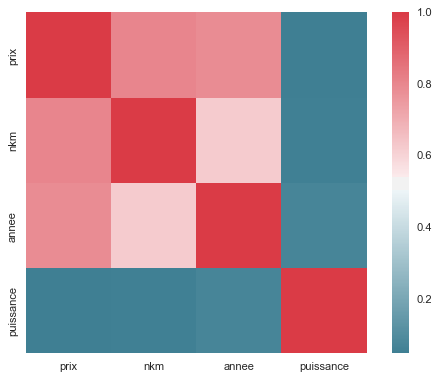

In [113]:
col=['prix','nkm', 'annee', 'puissance']
dfx=dfc[col]; dfx=dfx[dfc!=0]
corr=dfx[col].corr()
sns.heatmap(np.abs(corr), mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True)

## PRIX (km , Année) cote argus

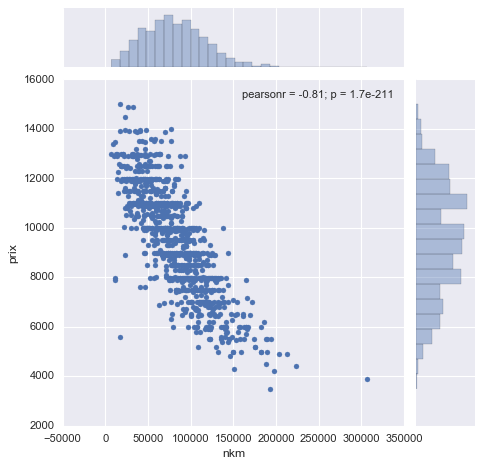

In [82]:
sns.jointplot(x="nkm", y="prix", data=dfc);

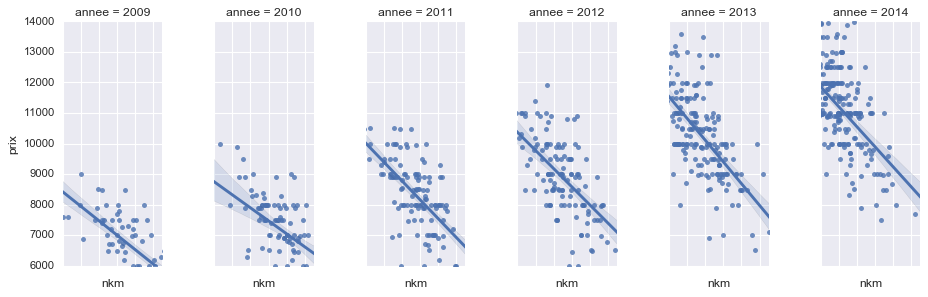

In [75]:
ax = sns.lmplot(x="nkm", y="prix",col="annee", data=dfc,size=4, aspect=0.5)
ax.set(ylim=(6000, None),xlim=(40000, 150000))
ax.set(ylim=(6000, 14000))
ax.set(xticklabels=[])

## puissance  du moteur 

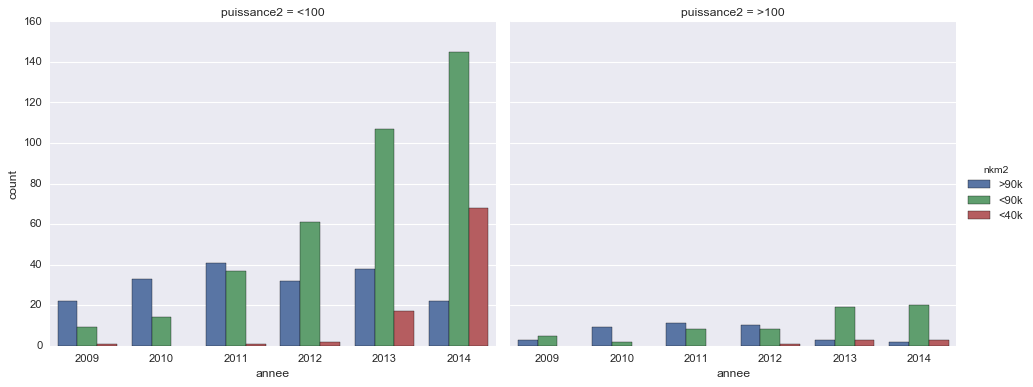

In [91]:
g = sns.factorplot(x="annee", col="puissance2", hue="nkm2",data=dfc, kind="count",size=5, aspect=1.2);

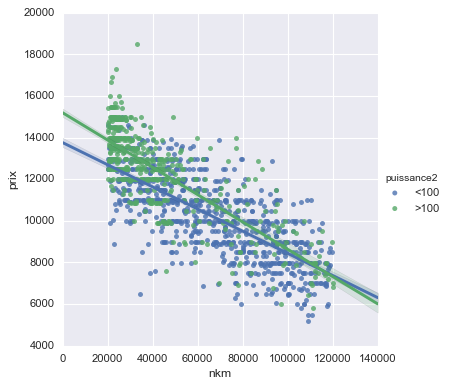

In [92]:
dfc=df.copy()
dfc=dfc[(dfc.nkm<=120000)&(dfc.nkm>20000)]
sns.lmplot(x="nkm", y="prix",hue='puissance2', data=dfc);

## finitions

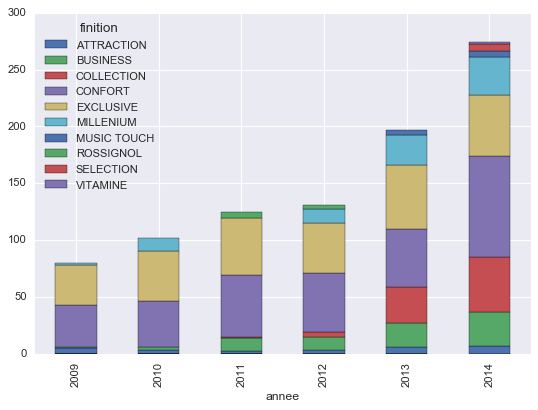

In [102]:
#PLot count empilé 
df3=dfc.groupby('annee').finition.value_counts()
df3.unstack().plot(kind='bar', stacked=True)

### vendeur pro vs particulier

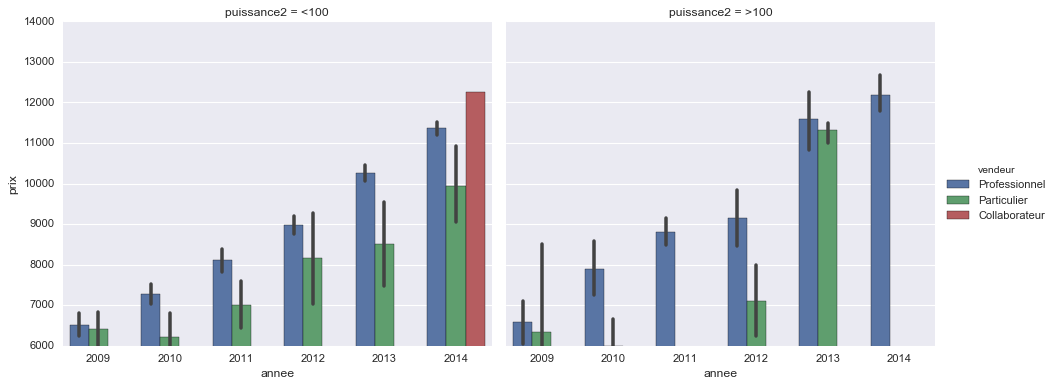

In [100]:
g = sns.factorplot(x="annee", y="prix",hue="vendeur", col="puissance2",data=dfc, kind="bar",size=5, aspect=1.2,);
g.set(ylim=(6000, None))